In [1]:
import os 
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scanpy as sc
import anndata as ann
import diffxpy.api as de
import batchglm.api as glm
from batchglm.pkg_constants import TF_CONFIG_PROTO
#data integration package
#import scIB 
import scanpy.external as sce

from scipy.sparse import csr_matrix
from matplotlib import rcParams
from matplotlib import colors

#import rpy2.rinterface_lib.callbacks
import logging, warnings
#from rpy2.robjects import pandas2ri
#import anndata2ri


sc.settings.verbosity = 3
sc.logging.print_versions()

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.4 scipy==1.4.1 pandas==0.25.3 scikit-learn==0.22 statsmodels==0.11.0rc1 python-igraph==0.7.1 louvain==0.6.1


In [58]:
adata.obs['sample_id'].value_counts()

ELS-71     3081
ELS-113    2970
ELS-7      2785
ELS-23     2708
ELS-27     2646
ELS-73     2601
ELS-47     2361
ELS-11     2184
ELS-109    2078
ELS-103    2043
ELS-37     2024
ELS-105     686
Name: sample_id, dtype: int64

In [2]:
plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()
de.__version__

logging.getLogger("tensorflow").setLevel(logging.ERROR)
logging.getLogger("batchglm").setLevel(logging.INFO)
logging.getLogger("diffxpy").setLevel(logging.INFO)

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 35)
warnings.filterwarnings("ignore", category=DeprecationWarning, module="tensorflow")

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.4 scipy==1.4.1 pandas==0.25.3 scikit-learn==0.22 statsmodels==0.11.0rc1 python-igraph==0.7.1 louvain==0.6.1


In [3]:
#Set number of threads
TF_CONFIG_PROTO.inter_op_parallelism_threads = 1
TF_CONFIG_PROTO.intra_op_parallelism_threads = 12

In [70]:
adata = sc.read('./../data/processed/cellxgene.h5ad')

In [71]:
adata.rename_categories('louvain', ['Astro 1', 'Oligo 1', 'CCK 1', 'Oligo 2', 'Glut 1', 'Endothelial',\
                                    'Glut 2', 'Microglia 1', 'OPCs', 'Microglia 2', \
                                    'CCK 2 (?)', 'Pericytes', 'Glut 3', 'CCK 3', 'GABA', \
                                    'Endothelial 2', 'Astro 2', 'Cajal-Retzius', 'Astro 3', \
                                    'Neurons (?)', 'Oligo (?)', 'Choroid Plexus', 'Ependymal', \
                                    'CCK 4', 'NPCs', 'Vascular', 'Macrophages', 'Meningeal', '??'])

In [6]:
#Load saved diffxpy results
import pickle 
with open('../results/diffxpy_louvain.pickle', 'rb') as f:
    de_results_louvain = pickle.load(f)
with open('../results/diffxpy_celltype.pickle', 'rb') as f:
    de_results_celltype = pickle.load(f)

# Look at the results

In [7]:
de_results_listofdicts = []
for i, item in enumerate(de_results_celltype):
    de_results_dict = {
        'cell_type': de_results_celltype[i],
        'louvain': de_results_louvain[i]    
    }
    if i == 0:
        de_results_dict['pairtest'] = 'BL Ctrl vs BL Stress'
    elif i == 1:
        de_results_dict['pairtest'] = 'ELS Ctrl vs ELS Stress'
    elif i == 2:
        de_results_dict['pairtest'] = 'BL Ctrl vs ELS Ctrl'
    elif i == 3:
        de_results_dict['pairtest'] = 'BL Stress vs ELS Stress'
    de_results_listofdicts.append(de_results_dict)

In [8]:
def de_postprocessing(de_results_listofdicts, adata):
    de_post = []
    
    for de_results_dict in de_results_listofdicts:
        for clust_type in ['cell_type', 'louvain']:
            for clust in de_results_dict[clust_type]:
                if clust in adata.obs[clust_type].cat.categories:
                    tmp = de_results_dict[clust_type][clust].summary()
                    n_infll = np.sum(tmp['ll'] == np.float64('-inf'))
                    tmp = tmp.loc[tmp['ll'] != np.float64('-inf')]
    
                    #Sort values by q-value
                    tmp.sort_values(by='qval', ascending=True, inplace=True)
        
                    de_post.append({'clust': clust, 
                              'clust_type': clust_type, 
                              'de_post': tmp.copy(), 
                              'de_raw': de_results_dict[clust_type][clust],
                              'pairtest': de_results_dict['pairtest']
                             })
            
    de_post_df = pd.DataFrame(de_post)
    del de_post
    
    de_post_df['ndeg_0.05'] = ''
    de_post_df['ndeg_0.01'] = ''
    
    for index, row in de_post_df.iterrows():
        de_post_df.loc[index]['ndeg_0.05'] = row['de_post'].loc[(row['de_post']['qval']<0.05)].shape[0]
        de_post_df.loc[index]['ndeg_0.01'] = row['de_post'].loc[(row['de_post']['qval']<0.01)].shape[0]
       
    return de_post_df

In [9]:
de_post_df = de_postprocessing(de_results_listofdicts, adata)

/usr/local/lib/python3.7/site-packages/sparse/_coo/umath.py:491: RuntimeWarning: invalid value encountered in true_divide
  fill_value = self.func(*zero_args, **self.kwargs)[()]
/usr/local/lib/python3.7/site-packages/sparse/_coo/umath.py:491: RuntimeWarning: invalid value encountered in true_divide
  fill_value = self.func(*zero_args, **self.kwargs)[()]
/usr/local/lib/python3.7/site-packages/sparse/_coo/umath.py:491: RuntimeWarning: invalid value encountered in true_divide
  fill_value = self.func(*zero_args, **self.kwargs)[()]
/usr/local/lib/python3.7/site-packages/sparse/_coo/umath.py:491: RuntimeWarning: invalid value encountered in true_divide
  fill_value = self.func(*zero_args, **self.kwargs)[()]
/usr/local/lib/python3.7/site-packages/sparse/_coo/umath.py:491: RuntimeWarning: invalid value encountered in true_divide
  fill_value = self.func(*zero_args, **self.kwargs)[()]
/usr/local/lib/python3.7/site-packages/sparse/_coo/umath.py:491: RuntimeWarning: invalid value encountered in 

BL Ctrl vs BL Stress
ELS Ctrl vs ELS Stress
BL Ctrl vs ELS Ctrl
BL Stress vs ELS Stress


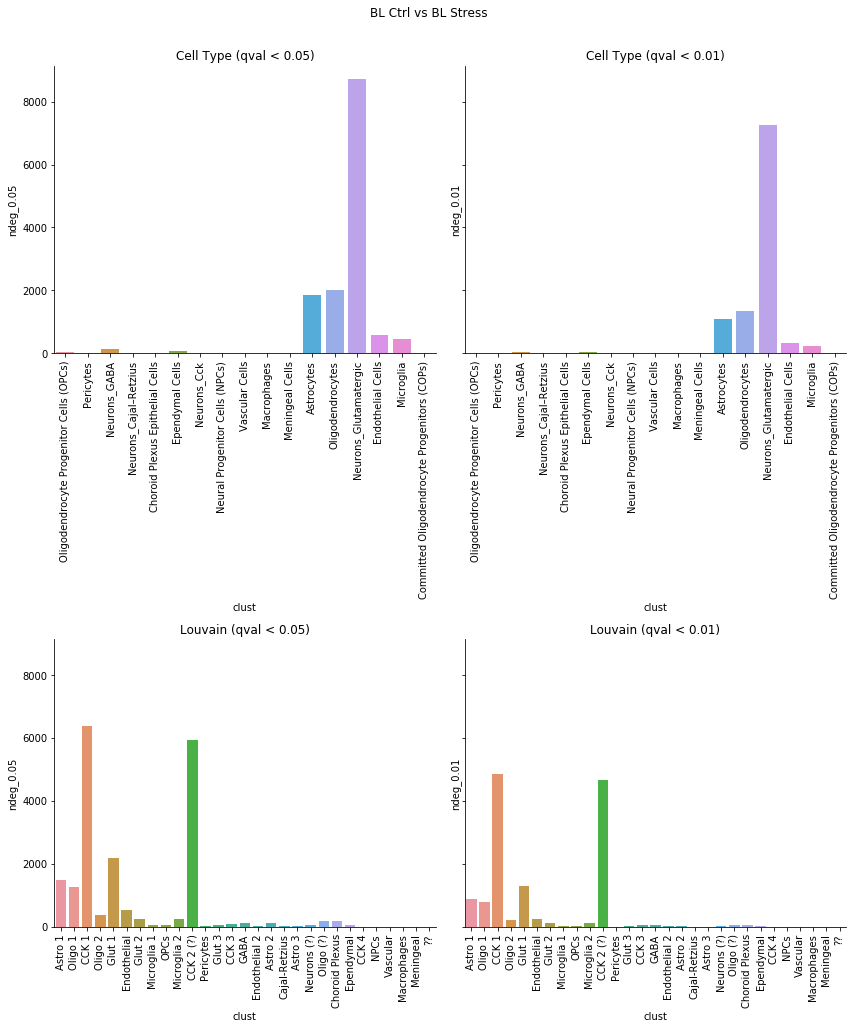

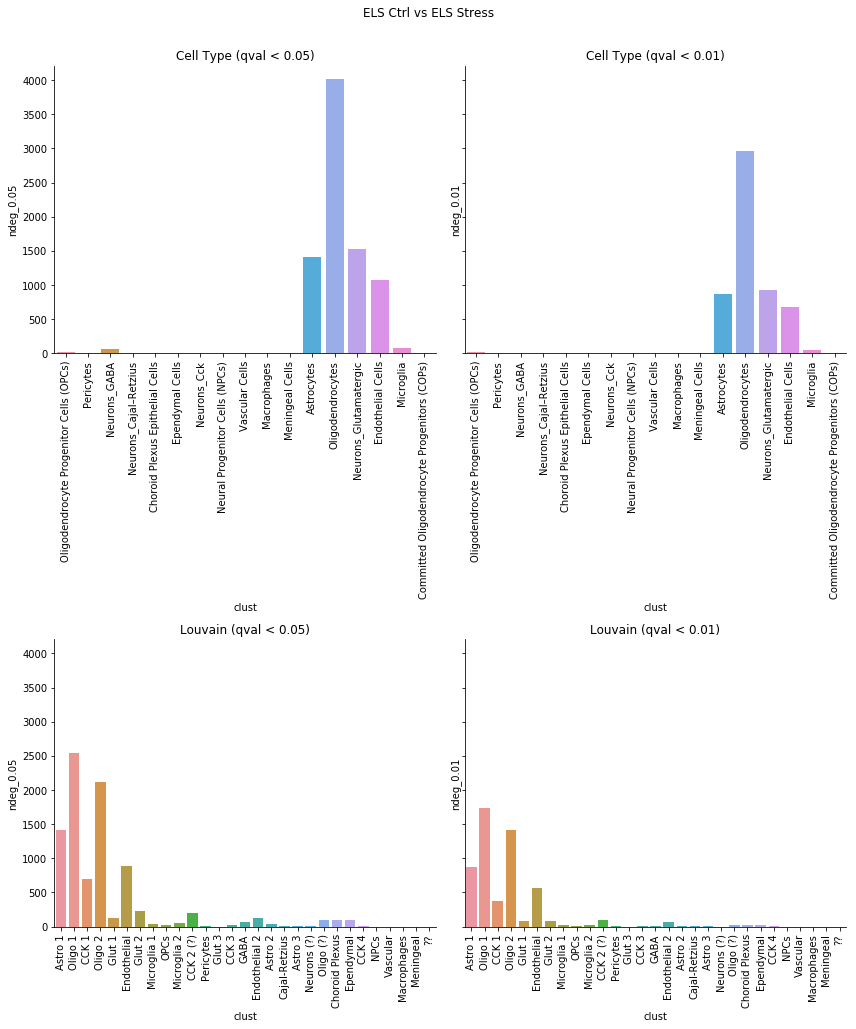

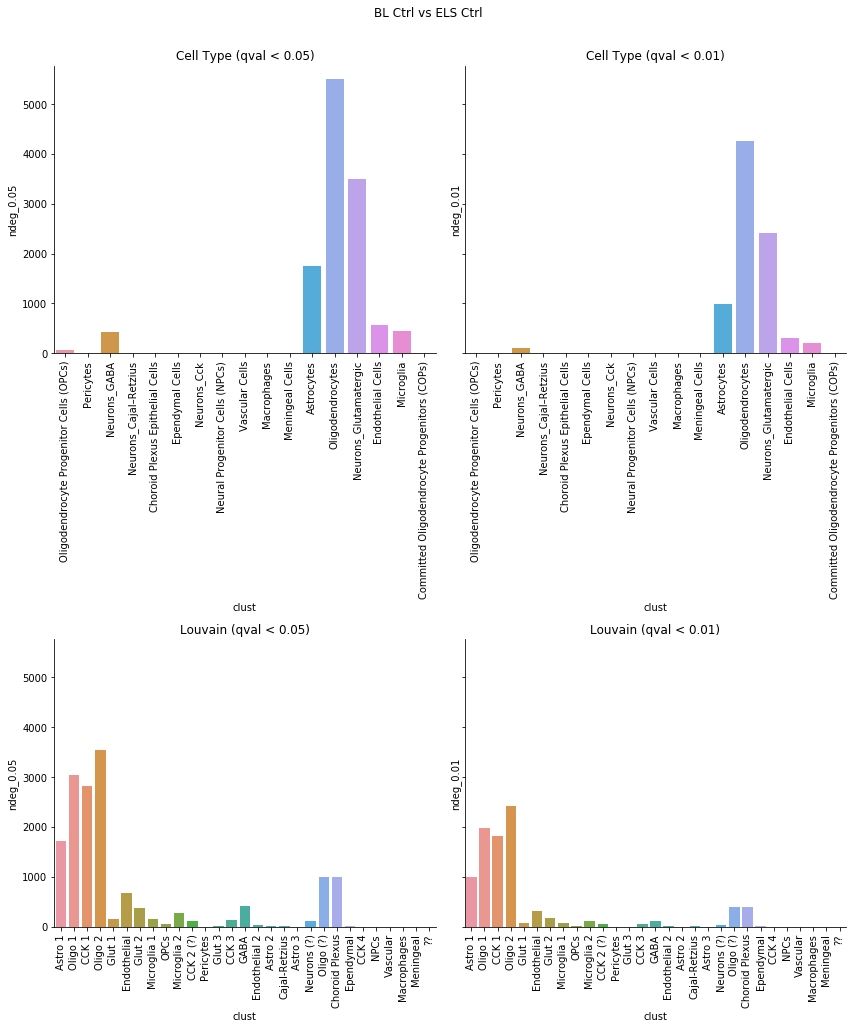

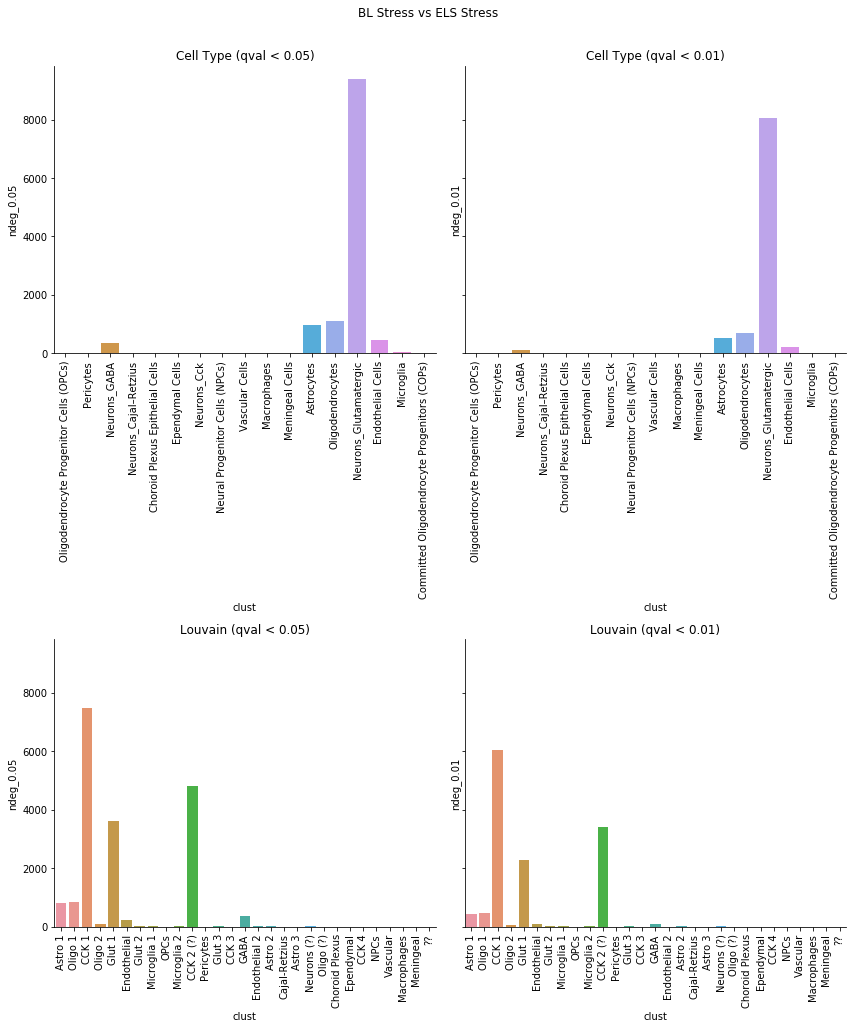

In [64]:
for pairtest in de_post_df['pairtest'].unique():
    print(pairtest)
    fig, ax = plt.subplots(2, 2, figsize=(12, 15), sharey=True)
    
    tmp_df = de_post_df[de_post_df['pairtest']== pairtest]
    
    tmp_df_celltype = tmp_df[tmp_df['clust_type']=='cell_type']
    sns.barplot(x='clust', y='ndeg_0.05', data=tmp_df_celltype, ax=ax[0, 0])
    ax[0, 0].set_xticklabels(ax[0, 0].get_xticklabels(), rotation=90)
    ax[0, 0].set_title('Cell Type (qval < 0.05)')

    sns.barplot(x='clust', y='ndeg_0.01', data=tmp_df_celltype, ax=ax[0, 1])
    ax[0, 1].set_xticklabels(ax[0, 1].get_xticklabels(), rotation=90)
    ax[0, 1].set_title('Cell Type (qval < 0.01)')

    tmp_df_louvain = tmp_df[tmp_df['clust_type']=='louvain']
    sns.barplot(x='clust', y='ndeg_0.05', data=tmp_df_louvain, ax=ax[1, 0])
    ax[1, 0].set_xticklabels(ax[1, 0].get_xticklabels(), rotation=90)
    ax[1, 0].set_title('Louvain (qval < 0.05)')

    sns.barplot(x='clust', y='ndeg_0.01', data=tmp_df_louvain, ax=ax[1, 1])
    ax[1, 1].set_xticklabels(ax[1, 1].get_xticklabels(), rotation=90)
    ax[1, 1].set_title('Louvain (qval < 0.01)')
    sns.despine()
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.suptitle(pairtest)
    fig.savefig('../figures/DE_' + pairtest.replace(' ', '_') + '.png', dpi=200)

In [10]:
adata.obs['louvain'].value_counts()

Astro 1           4690
Oligo 1           3422
CCK 1             2903
Oligo 2           2447
Glut 1            2032
Endothelial       1973
Glut 2            1561
Microglia 1       1310
OPCs               823
Microglia 2        809
CCK 2 (?)          692
Pericytes          497
Glut 3             473
CCK 3              445
GABA               418
Endothelial 2      390
Astro 2            375
Cajal-Retzius      358
Astro 3            352
Neurons (?)        349
Oligo (?)          340
Choroid Plexus     294
Ependymal          272
CCK 4              259
NPCs               255
Vascular           149
Macrophages        120
Meningeal          100
??                  59
Name: louvain, dtype: int64

BL Ctrl vs BL Stress louvain Astro 1


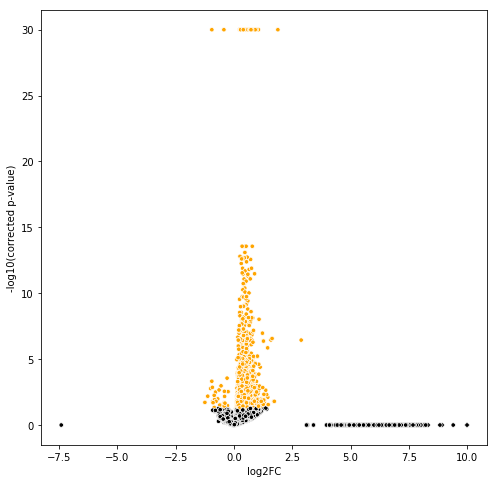

BL Ctrl vs BL Stress louvain Oligo 1


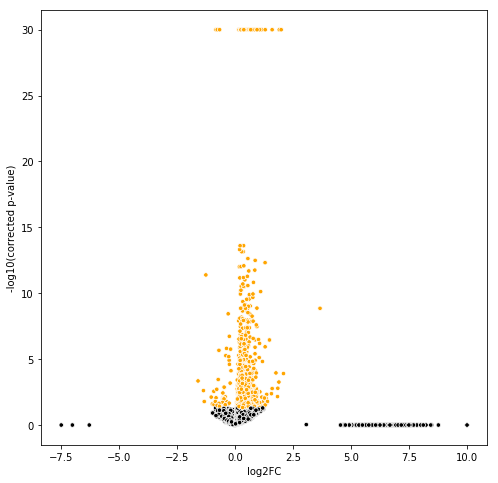

BL Ctrl vs BL Stress louvain CCK 1


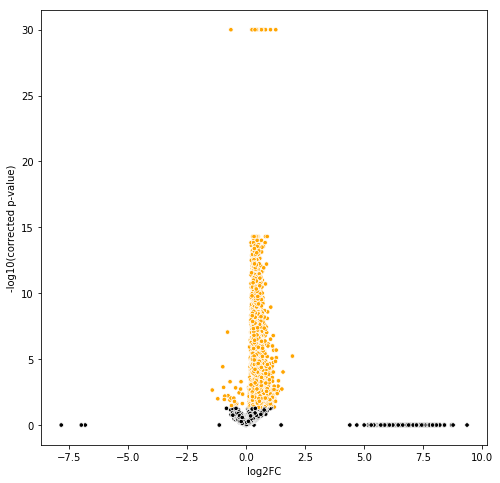

BL Ctrl vs BL Stress louvain Oligo 2


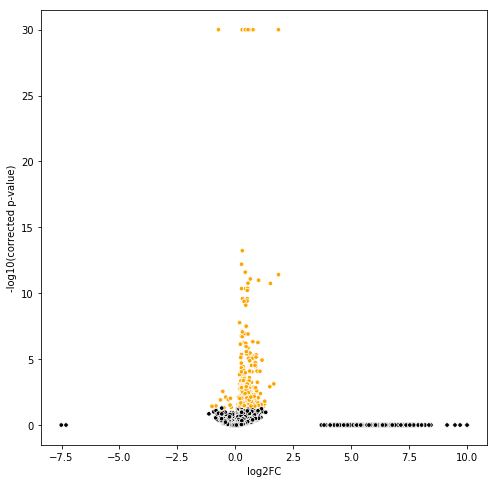

BL Ctrl vs BL Stress louvain Glut 1


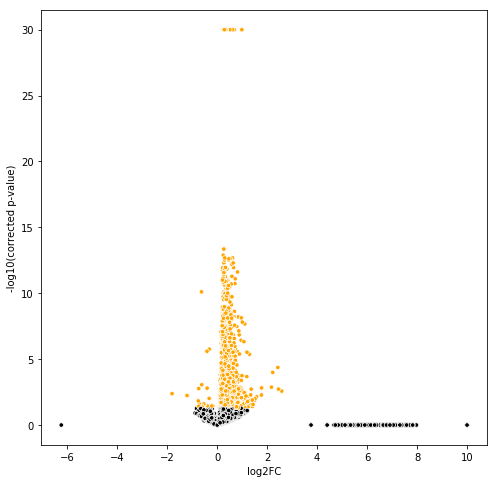

BL Ctrl vs BL Stress louvain Endothelial


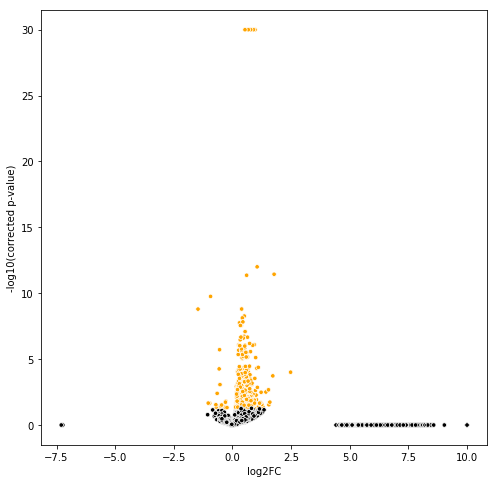

BL Ctrl vs BL Stress louvain Glut 2


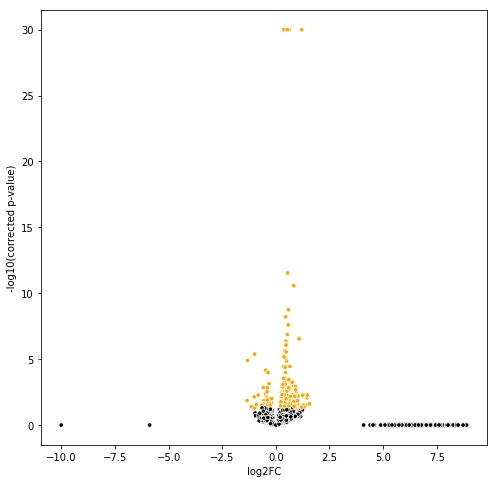

BL Ctrl vs BL Stress louvain Microglia 1


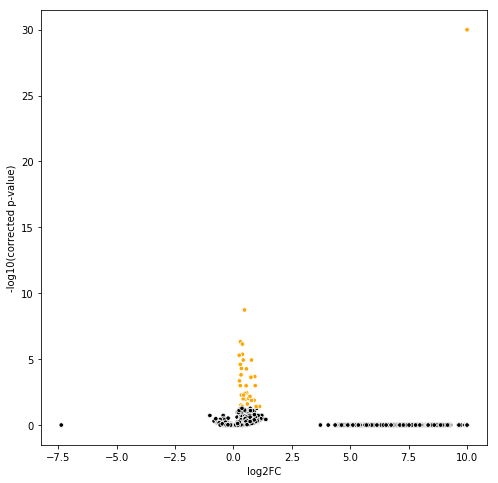

BL Ctrl vs BL Stress louvain OPCs


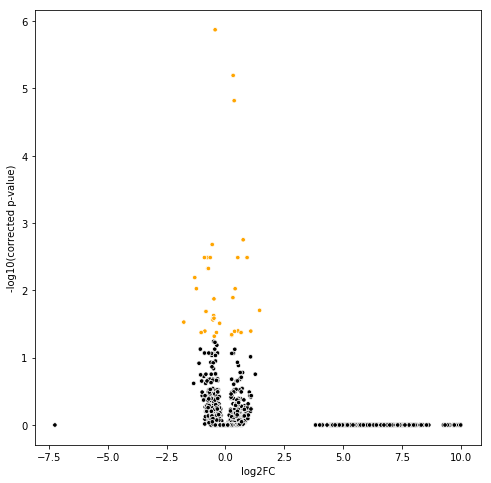

BL Ctrl vs BL Stress louvain Microglia 2


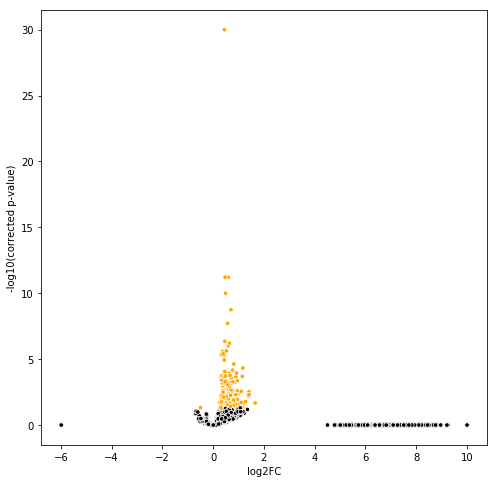

BL Ctrl vs BL Stress louvain CCK 2 (?)


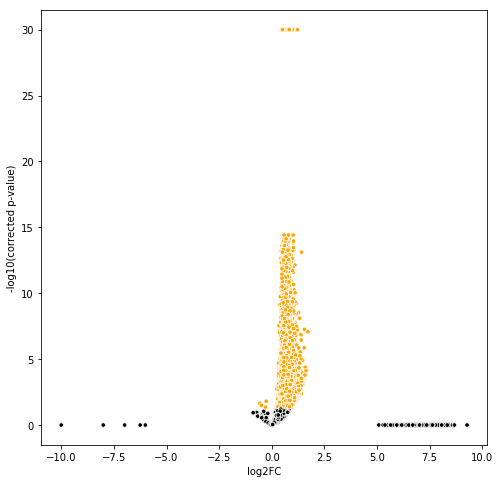

BL Ctrl vs BL Stress louvain Pericytes


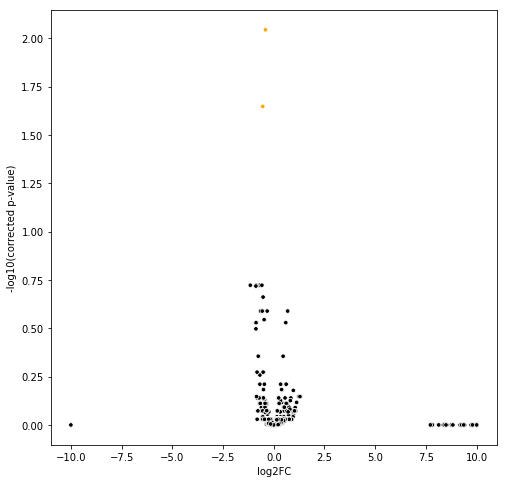

BL Ctrl vs BL Stress louvain Glut 3


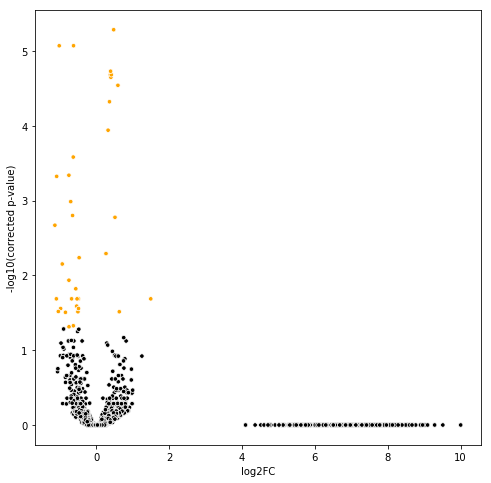

BL Ctrl vs BL Stress louvain CCK 3


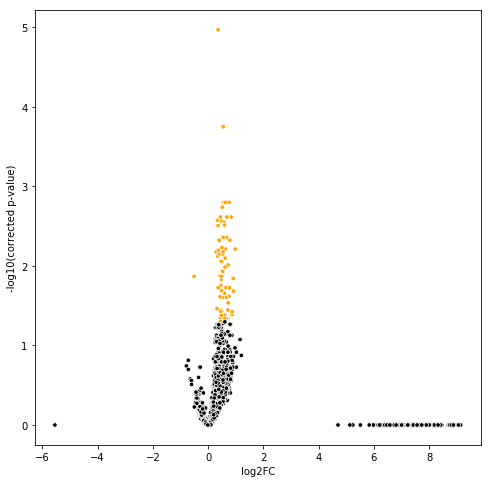

BL Ctrl vs BL Stress louvain GABA


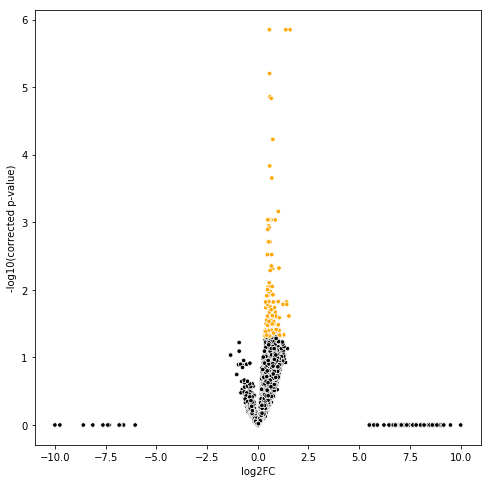

BL Ctrl vs BL Stress louvain Endothelial 2


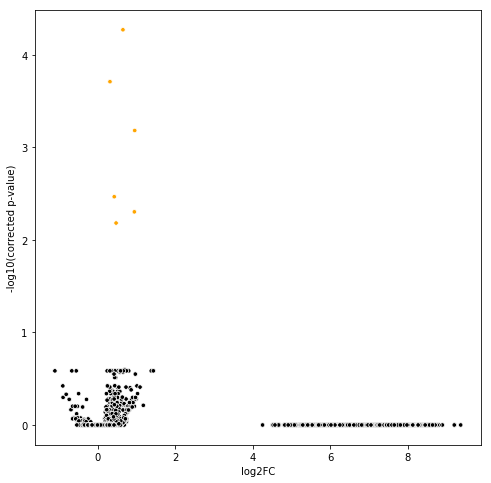

BL Ctrl vs BL Stress louvain Astro 2


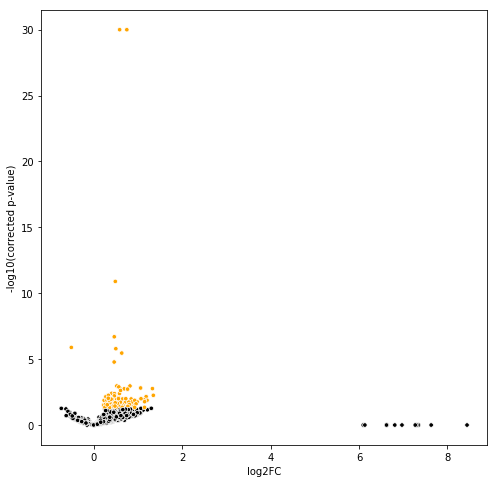

BL Ctrl vs BL Stress louvain Cajal-Retzius


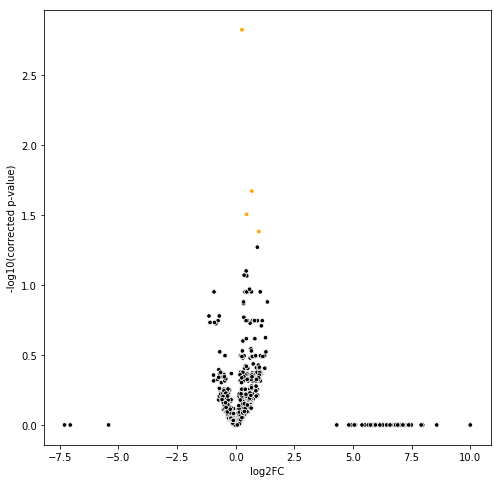

BL Ctrl vs BL Stress louvain Astro 3


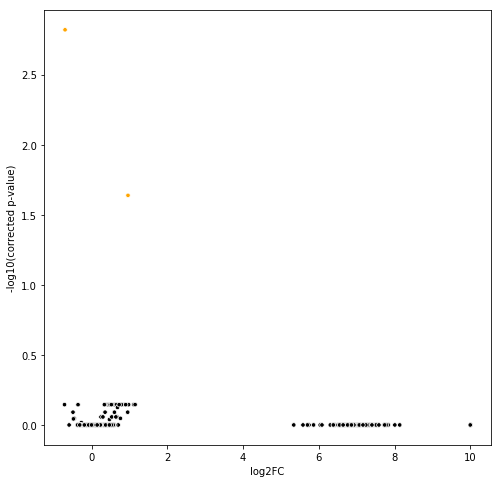

BL Ctrl vs BL Stress louvain Neurons (?)


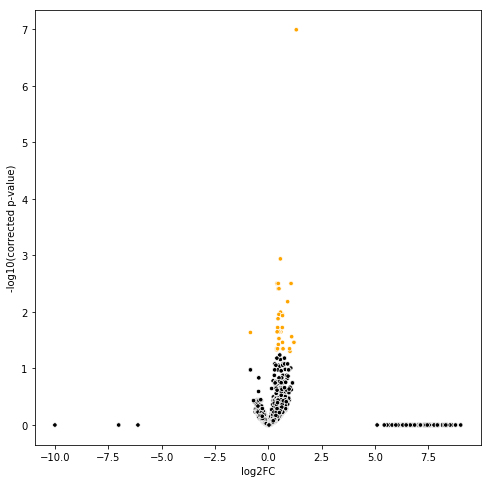

BL Ctrl vs BL Stress louvain Oligo (?)


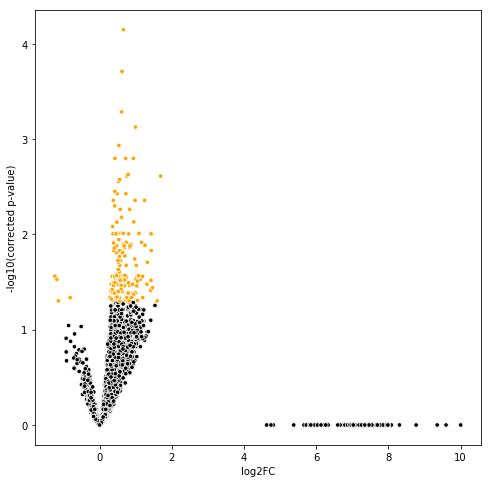

BL Ctrl vs BL Stress louvain Choroid Plexus


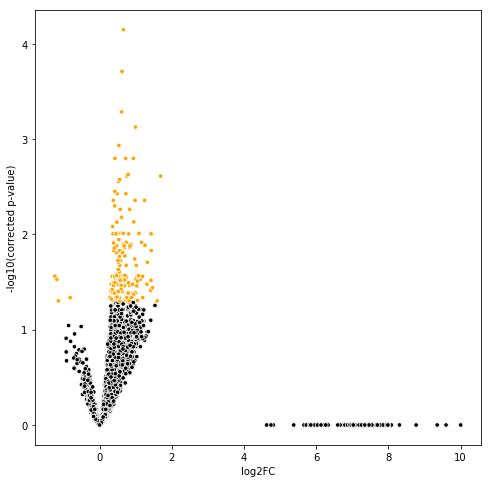

BL Ctrl vs BL Stress louvain Ependymal


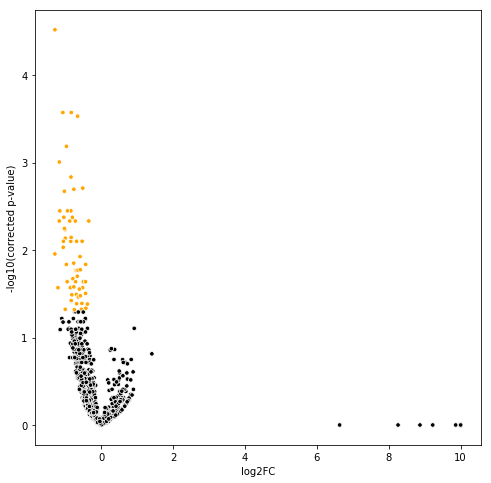

BL Ctrl vs BL Stress louvain CCK 4


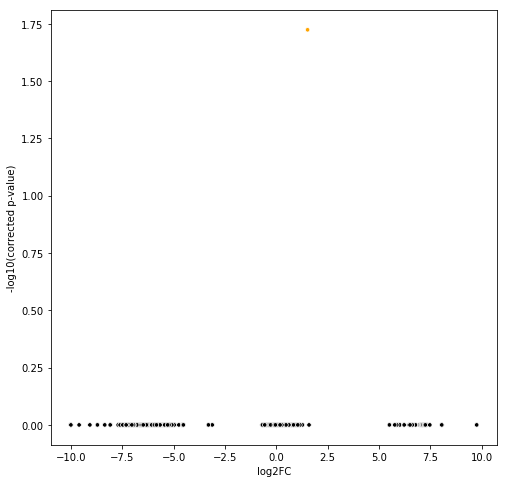

BL Ctrl vs BL Stress louvain NPCs


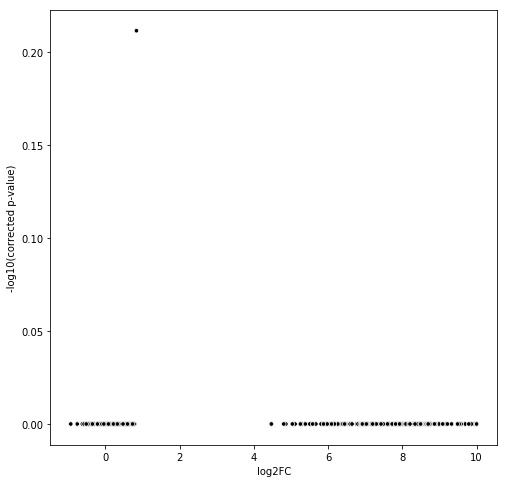

BL Ctrl vs BL Stress louvain Vascular


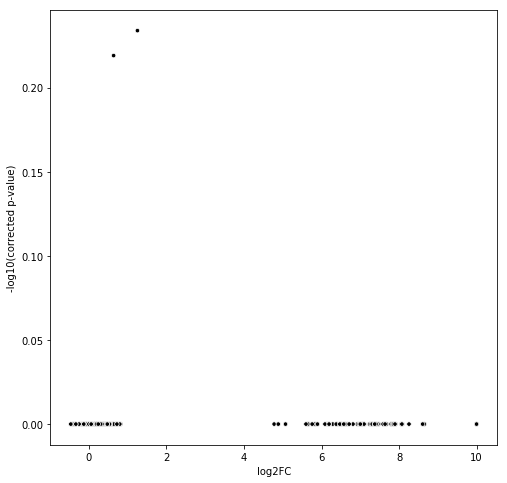

BL Ctrl vs BL Stress louvain Macrophages


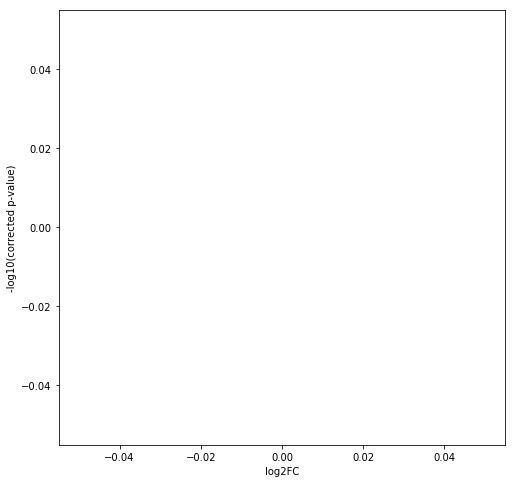

BL Ctrl vs BL Stress louvain Meningeal


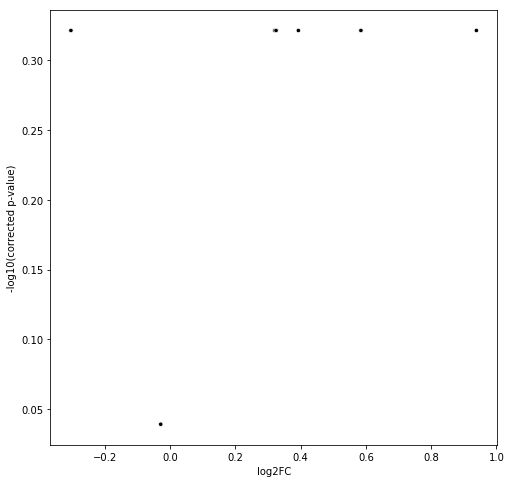

BL Ctrl vs BL Stress louvain ??


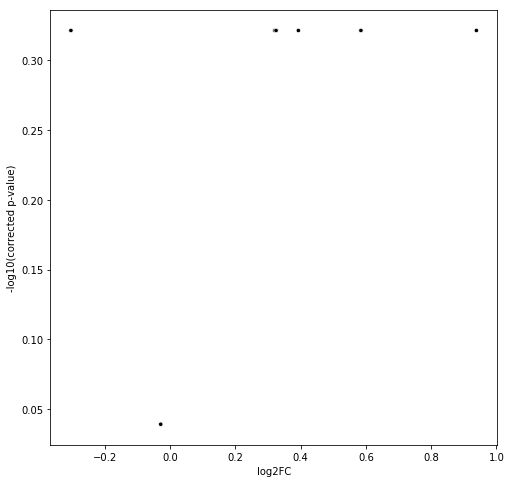

In [274]:
tmp_volcano = de_post_df[de_post_df['pairtest']=='BL Ctrl vs BL Stress']
tmp_volcano = tmp_volcano[tmp_volcano['clust_type']=='louvain']
for index, row in tmp_volcano.iterrows():
    print(' '.join([row['pairtest'], row['clust_type'], row['clust']]))
    de_post_df.loc[index]['de_raw'].plot_volcano()

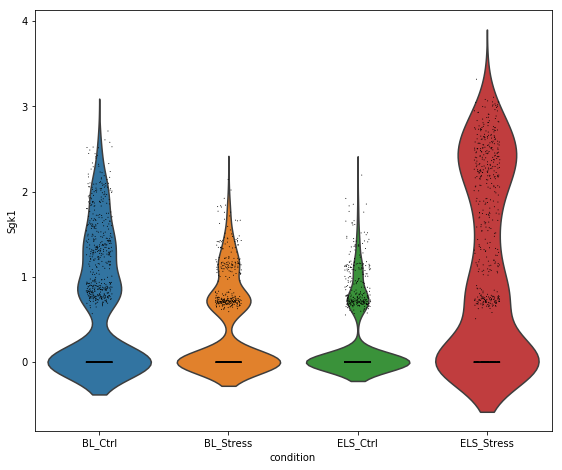

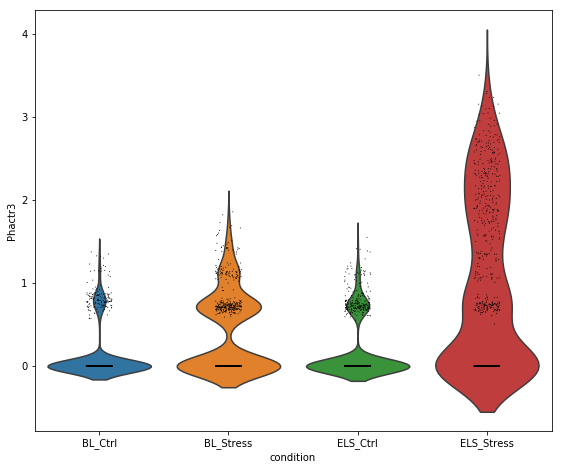

In [55]:
adata_clust = adata[adata.obs.louvain.isin(['Oligo 1']),:]
sc.pl.violin(adata_clust, keys='Sgk1', groupby='condition', layer='counts')
adata_clust = adata[adata.obs.louvain.isin(['Oligo 1']),:]
sc.pl.violin(adata_clust, keys='Phactr3', groupby='condition')

In [51]:
check = de_post_df[(de_post_df['pairtest'] == 'BL Ctrl vs BL Stress') & (de_post_df['clust']=='Oligo 1')]
tmp = check.iloc[0]['de_raw'].summary().sort_values(by='qval')
print(tmp[tmp['gene'] == 'Cdkn1a'])
check = de_post_df[(de_post_df['pairtest'] == 'BL Ctrl vs BL Stress') & (de_post_df['clust']=='Oligo 1')]
tmp = check.iloc[0]['de_raw'].summary().sort_values(by='qval')
print(tmp[tmp['gene'] == 'Cdkn1a'])

        gene      pval  qval     log2fc      mean  zero_mean          grad  \
7006  Cdkn1a  0.998385   1.0  17.540553  0.470588      False  2.261426e-09   

       coef_mle      coef_sd           ll  
7006  17.540553  8668.006252 -1066.062001  
        gene      pval  qval     log2fc      mean  zero_mean          grad  \
7006  Cdkn1a  0.998385   1.0  17.540553  0.470588      False  2.261426e-09   

       coef_mle      coef_sd           ll  
7006  17.540553  8668.006252 -1066.062001  


In [52]:
check.iloc[0]['de_post']

,gene,pval,qval,log2fc,mean,zero_mean,grad,coef_mle,coef_sd,ll
1038,Phactr3,0.000000,0.0,1.147090,0.415403,False,2.264945e-08,1.147090,0.126485,-1261.512270
5756,Elmo1,0.000000,0.0,1.068375,0.426319,False,7.177144e-10,1.068375,0.122521,-1278.003873
6842,Olig1,0.000000,0.0,0.440842,3.802911,False,1.424034e-07,0.440842,0.041518,-3402.276789
4736,Hspa8,0.000000,0.0,0.663522,4.778047,False,2.876133e-07,0.663522,0.037440,-3495.772111
2621,Arpc1a,0.000000,0.0,0.550162,2.668284,False,6.181077e-08,0.550162,0.048224,-3084.755531
...,...,...,...,...,...,...,...,...,...,...
3606,Lats1,0.998579,1.0,6.529780,0.039418,False,6.163976e-09,6.529780,3666.772051,-269.991725
723,Cry2,0.998923,1.0,7.068481,0.047908,False,6.638765e-10,7.068481,5235.189567,-301.185315
2246,Slbp,0.951810,1.0,0.014934,0.060036,False,3.252460e-10,0.014934,0.247111,-366.414603
7257,Zfp438,0.998933,1.0,7.247775,0.047908,False,3.425971e-10,7.247775,5419.424311,-308.296480


In [65]:
l = adata.obs['sample_id'] == 'ELS-105'

In [67]:
len(l)

28167

In [68]:
adata.shape

(28167, 18928)

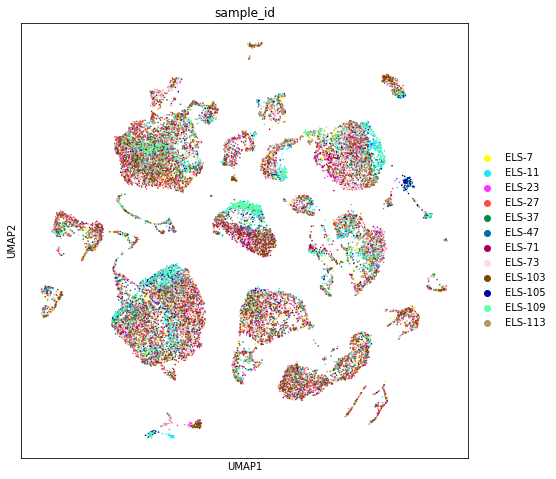

In [84]:
sc.pl.umap(adata, color='sample_id', size=10, palette=sc.pl.palettes.default_64)

In [85]:
adata[adata.obs['sample_id']=='ELS-7']

IndexError: index 46 is out of bounds for axis 0 with size 45

In [57]:
adata.obs['condition'][adata.obs['louvain'].isin(['Oligo 1', 'Oligo 2'].value_counts()

SyntaxError: unexpected EOF while parsing (<ipython-input-57-0319461a3182>, line 1)

In [33]:
adata.obs['condition'][adata.obs['louvain']=='Oligo 2'].value_counts()

ELS_Stress    819
BL_Stress     751
ELS_Ctrl      497
BL_Ctrl       380
Name: condition, dtype: int64